In [3]:
import datetime as dt
from datetime import datetime
import numpy as np
import math
import pandas as pd 
from pandas_datareader import DataReader
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
plt.rcParams["figure.figsize"] = (20,10)

moneda = 'BTC-USD'
#Ventana de tiempo, en este caso uno, que es diario.
window = 30

cripto_m = DataReader(str(moneda), "yahoo")
rolling = cripto_m['Close'].rolling(window = window)    
cripto_MA = rolling.mean()
cripto_MA = cripto_MA[-32:]

lista = np.array(np.log(cripto_MA))
fecha = np.arange(1,len(lista)+1)
window_e = 10
count = 0.0
dataset_RMSEE = pd.DataFrame()
merged_data_RMSEE = pd.DataFrame()
for i in range(0, len(lista)):
    for j in range(i,(window_e+i)):
        count += -1 * (lista[j] * math.log(lista[j]))
        
    dataset_RMSEE = np.array((count)*(1/window_e))
    dataset_RMSEE = pd.DataFrame(dataset_RMSEE.reshape(1,1))
    dataset_RMSEE.index = [fecha[i]]
    merged_data_RMSEE = merged_data_RMSEE.append(dataset_RMSEE)
    count = 0
    if(i == (len(lista)-window_e)):
        break
        
merged_data_RMSEE.columns = ['Close']
no_clusters = 3
kmeans = KMeans(n_clusters = no_clusters, random_state=170).fit(np.array(merged_data_RMSEE))

def k_means(data, no_clusters):
    kmeans = KMeans(n_clusters=no_clusters, random_state=170).fit(np.array(data))
    data2 = data.copy()
    data2["clusters"] = kmeans.labels_
    data2["nombre"] = "Cluster"

    data2["clusters"] = data2["nombre"].astype(str) + " " + data2["clusters"].astype(str)
    data2 = data2.drop(['nombre'], axis=1)
    return data2

k_m = k_means(merged_data_RMSEE, no_clusters)

import plotly.express as px
fig = px.scatter(k_m, x=k_m.index, y="Close", color="clusters", title = 'Clusters')
fig.show()

df = pd.DataFrame(dict(x = k_m.index, y=k_m['Close'], label=k_m['clusters']))
n_cluster = np.zeros(3)
groups = df.groupby('label')

for label in df['label']:
    if (label == 'Cluster 0'):
        n_cluster[0] += 1
    elif (label == 'Cluster 1'):
        n_cluster[1] += 1
    else:
        n_cluster[2] += 1
        
pos = {0 : 0, 1: 1, 2 : 2}                
etiqueta = {0 : 'Compra', 1 : 'Vende', 2 : 'Insertidumbre'}
color = {0 : 'green',1 : 'red',2 : 'yellow'}

#fig, ax = plt.subplots()
#for name, group in groups:
#    if(name == 'Cluster 0'):
#        ax.plot(group.x, group.y, marker='o', linestyle='', ms=5, label='Incertidumbre', color = 'yellow')
#    elif(name == 'Cluster 1'):
#        ax.plot(group.x, group.y, marker='o', linestyle='', ms=5, label='Vende', color = 'red')
#    elif(name == 'Cluster 2'):
#        ax.plot(group.x, group.y, marker='o', linestyle='', ms=5, label='Compra', color = 'green')
#ax.legend()
#plt.show()

nl_cluster = n_cluster[::-1]

#plt.title('Escala de tiempo diario')
#graph, = plt.plot(cripto_MA, color = color[len(nl_cluster) - np.argmax(nl_cluster) - 1],label = etiqueta[len(nl_cluster) - np.argmax(nl_cluster) - 1])
#plt.legend(handles=[graph],loc='upper left')
#plt.show()

vis = cripto_MA

s = pd.Series(np.arange(len(cripto_MA)))*2
cripto_MA = pd.DataFrame(cripto_MA)
cripto_MA = cripto_MA.set_index(s)
df_aux = cripto_MA 

for i in range(5):
    s = pd.Series(np.arange(len(df_aux)))*2
    df_aux = df_aux.set_index(s)
    index = np.arange(len(df_aux)*2)
    df_aux = df_aux.reindex(index)
    df_aux = df_aux.interpolate(method='spline', order=1)

cripto_MA = df_aux


from PIL import Image
def img():
    tam = 32
    dataset = np.log(cripto_MA)
    data_img = np.asarray(dataset)
    mini = min(data_img)
    maxi = max(data_img)
    x = 0 
    y = 0
    df = np.zeros((tam, tam)).astype(np.uint8)
    for k in range(len(data_img)):
        df[y][x] = np.round((data_img[k] - mini) / (maxi - mini)*255)
        x+=1
        if(x == tam):
            y+=1
            x = 0
            
    img = Image.fromarray(df)    
    return img

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 128)       36992     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0

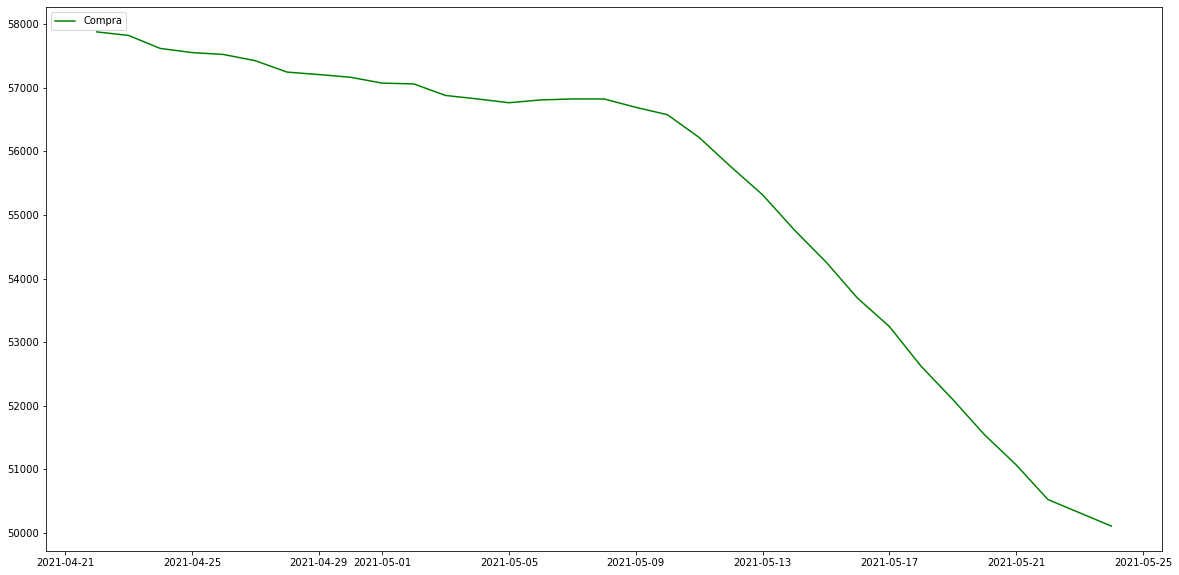

In [4]:
model = tf.keras.models.load_model('CNN_BTC-USD_1.h5')
model.summary()

imagen = img()

imagen = np.asarray(imagen).reshape(-1,32,32,1)
imagen = tf.cast(imagen, tf.float32)

etiqueta = ['Compra', 'Vende', 'Incertidumbre']
predictions = model.predict(imagen)
score = tf.nn.softmax(predictions[0])

#n_cluster es un array con la cantidad de elementos de cada cluster
#En n_cluster el elemento cero del array es compra el uno es vende y el dos es incertidumbre.
graph, = plt.plot(vis,color = color[pos[np.argmax(score)]], label = etiqueta[pos[np.argmax(score)]])
plt.legend(handles=[graph],loc='upper left')
#print(vis)
print("\033[1m {} \033[0m ".format(etiqueta[pos[np.argmax(score)]]))
print('Color: ',color[pos[np.argmax(score)]])
print(n_cluster)
print(score)